In [1]:
from pathlib import Path
from collections import defaultdict
import glob
import itertools
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns

import sys
sys.path.append("./ComputeCanada/frequency_tagging")
from im_recall_precision import *

dlabel_dir = Path("/opt/app/notebooks/data/dlabels")
hcp_label = dlabel_dir / "Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii"

_HCP_INFO = !wb_command -file-information {hcp_label}
HCP_LABELS = []
HCP_COUNTER = 0
for i in _HCP_INFO:
    if len(i) == 60 and any(["L_" in i, "R_" in i]):
        hcp_colors = tuple([float(f"0.{k}") for k in [j.split(' ') [0] for j in i.split('0.')][-3:]] + [1])
        if ' R_' in i:
            roi = i.split("_ROI")[0].split(' R_')[1]
            HCP_LABELS.append(f"R_{roi}_ROI")
        if ' L_' in i:
            roi = i.split("_ROI")[0].split(' L_')[1]
            HCP_LABELS.append(f"L_{roi}_ROI")
        HCP_COUNTER += 1


In [2]:
dscalar_dir = Path("/opt/app/notebooks/data/dscalars")
tmpdir = Path("/tmp")
template_dscalar = dscalar_dir / "S1200.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii"

hcp_mapping = {}
for roi_label in HCP_LABELS:
    out_dscalar = tmpdir / f"{roi_label}.dscalar.nii"
    if out_dscalar.exists():
        hcp_mapping[roi_label] = out_dscalar
        continue
    !wb_command -cifti-label-to-roi {hcp_label} {out_dscalar} -name {roi_label}
    !wb_command -cifti-create-dense-from-template {template_dscalar} {out_dscalar} -cifti {out_dscalar}
    assert out_dscalar.exists(), f"{out_dscalar.stem} does not exist."
    hcp_mapping[roi_label] = out_dscalar
hcp_rois = list(set([k.split('_')[1] for k in hcp_mapping.keys()]))

In [3]:
def search(base_dir, wildcard, error=True):
    search_path = Path(base_dir) / wildcard
    files = glob.glob(str(search_path))

    if not files:
        if error:
            raise FileNotFoundError(f"No files were found in: {search_path}")
        else:
            return []

    return files

def filter_run_ids(run_ids):
    KEEP = ['01', '02', '03', 'IMTest', 'IMRetest']
    KEEP = [f"run-{i}" for i in KEEP]
    filtered_run_ids = []
    for run_id in run_ids:
        if run_id.split('/')[-1] in KEEP or "X" in run_id:
            filtered_run_ids.append(run_id)

    return filtered_run_ids

def get_voxel_count_per_hcp_label(updated_hcp_mapping, binary_mask, contra_hemi, ipsi_hemi):
    
    vertex_count_per_roi = {}
    for hcp_label, v in updated_hcp_mapping.items():
        base_label = "_".join(hcp_label.split("_")[1:])
        roi_mask = v[0]
        pct_coverage = v[1]

        if hcp_label.startswith(contra_hemi):
            normalized_hcp_label = f"CONTRA_{base_label}"
        elif hcp_label.startswith(ipsi_hemi):
            normalized_hcp_label = f"IPSI_{base_label}"

        new_mask = binary_mask * roi_mask
        n_vertices = new_mask.sum()

        vertex_count_per_roi[normalized_hcp_label] = n_vertices
    
    return vertex_count_per_roi

def get_distributions_per_hcp_label(task_data, metric_type, run_id, roi, updated_hcp_mapping, binary_mask, contra_hemi, ipsi_hemi):

    _base = roi.split("_")[1]
    if roi.startswith("CONTRA"):
        roi_label = f"{contra_hemi}_{_base}_ROI"
    elif roi.startswith("IPSI"):
        roi_label = f"{ipsi_hemi}_{_base}_ROI"

    print(roi, ">", roi_label)

    roi_mask = updated_hcp_mapping[roi_label][0]
    new_mask = binary_mask * roi_mask

    metric_data = task_data[metric_type][run_id]

    assert metric_data.shape == new_mask.shape

    metric_data = metric_data[new_mask == 1]
    
    return metric_data

def process_phase_delay(
    data: np.ndarray,
    stimulated_frequency: float,
):
    """
    """
    max_phasedelay = 1/float(stimulated_frequency) # in seconds
    max_indices = data == max_phasedelay
    non_max_indices = data != max_phasedelay
    data[max_indices] = 0 # Unphase max values: [0, max_phasedelay)
    data[non_max_indices] -= max_phasedelay / 2 # Move the stimulus to the right by pi/2 account for different between stimulus and sine wave
    data[non_max_indices] %= max_phasedelay # Rephase data: [0, max_phasedelay)

    return data

def get_mean_value(data, roi_dscalar, roidir):

    dscalar = roidir / roi_dscalar
    assert dscalar.exists(), f"{dscalar}"
    coords = nib.load(dscalar).get_fdata() == 1

    return data[coords].mean()

def sort_list_by_values(values, l):
    combined_l = zip(values, l)
    sorted_pairs = sorted(combined_l)
    sorted_l = [p[1] for p in sorted_pairs]
    sorted_values = [p[0] for p in sorted_pairs]

    return sorted_values, sorted_l

def sort_rois(rois, sorted_rois, sorted_values):

    assert len(sorted_rois) == len(sorted_values)
    
    value_per_roi = []
    for roi in rois:
        roi_base = roi.split("_")[1]
        v = sorted_rois.index(roi_base)
        value_per_roi.append(sorted_values[v])

    sorted_values, sorted_rois = sort_list_by_values(value_per_roi, rois)

    return sorted_values, sorted_rois    

def sort_rois_by_dscalar(rois, dscalar, roidir=Path("/tmp")):

    data = nib.load(dscalar).get_fdata()

    contra_rois = [i for i in rois if i.startswith("CONTRA")]
    ipsi_rois = [i for i in rois if i.startswith("IPSI")]

    unique_rois = list(set([i.split("_")[1] for i in rois]))
    dist = []
    for roi in unique_rois:
        L_dist = get_mean_value(data, f"L_{roi}_ROI.dscalar.nii", roidir)
        R_dist = get_mean_value(data, f"R_{roi}_ROI.dscalar.nii", roidir)
        dist.append(L_dist+R_dist)

    sorted_values, unique_rois = sort_list_by_values(dist, unique_rois)
    sorted_contra_values, sorted_contra_rois = sort_rois(contra_rois, unique_rois, sorted_values)
    contra_rois = zip(sorted_contra_rois, sorted_contra_values)
    sorted_ipsi_values, sorted_ipsi_rois = sort_rois(ipsi_rois, unique_rois, sorted_values)
    ipsi_rois = zip(sorted_ipsi_rois, sorted_ipsi_values)

    return contra_rois, ipsi_rois 

def plot_normalized_histograms(normalized_histograms, rois, _title, _range, dpi=200):

    fig, ax = plt.subplots(figsize=(5,2),dpi=dpi)
    count = np.vstack(normalized_histograms).T
    # Create imshow plot
    ax.imshow(
        count,
        aspect='auto', #extent=[min(bin_edges), max(bin_edges), 1, len(histograms)],
        cmap='viridis', origin='lower',
        vmax = count.max() / 2
    )

    ax.set_ylabel('Bins')
    ax.set_xticks([i for i in np.arange(0,len(rois),1)])
    ax.set_xticklabels(
        [f"{i.split('_')[1]}" for i in rois], 
        rotation=90, 
        fontsize=10, 
    )
    colors=['r' if i.split('_')[0] == "CONTRA" else 'b' for i in rois]
    for label, color in zip(ax.get_xticklabels(), colors):
        label.set_color(color)

    ax.set_title(f'{_title} Histograms [range: {_range[0]:.2f},{_range[1]:.2f}]')


In [4]:
scratch_dir = Path("/scratch/fastfmri")
IM_MODULATION_EXPERIMENT_IDS = ["020", "021"]
SUPPORTED_IDS = [
    "1_frequency_tagging_3T_entrain",
    #"1_frequency_tagging_7T_entrain",
    "1_attention_7T_AttendAway",
]
DSCALAR_TEMPLATE = "/opt/app/notebooks/data/dscalars/S1200.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii"


experiment_id = "1_frequency_tagging"
mri_id = "3T"
task_base = "entrain"
n_batches = 2
session_ids = ["run-ALL"]

assert f"{experiment_id}_{mri_id}_{task_base}" in SUPPORTED_IDS



sub_fla_dirs = search(scratch_dir, f"experiment-{experiment_id}_mri-{mri_id}*smooth-0*batch-00_desc-IMsubtraction_bootstrap/first_level_analysis/sub-*")
sub_fla_dirs.sort()
sub_ids = []
task_suffices = []
for i in sub_fla_dirs:
    _dir = Path(i)
    sub_id = _dir.stem
    if sub_id in [f"sub-{_id}" for _id in IM_MODULATION_EXPERIMENT_IDS]:
        continue
    sub_ids.append(sub_id)
    
    search_str = str(_dir).split("/")[3]
    truncate_id = search_str.split('truncate-')[1].split('_')[0]
    smooth_id = search_str.split('smooth-')[1].split('_')[0]

    tasks = search(scratch_dir, f"experiment-{experiment_id}*mri-{mri_id}*smooth-0*batch-00_desc-IMsubtraction_bootstrap/first_level_analysis/{sub_id}/*/task-{task_base}*")
    assert len(tasks) == 1
    task_suffix = tasks[0][-2:]
    task_suffices.append(task_suffix)

In [5]:
f_1, f_2, f_im = 0.125, 0.2, 0.075

n_datasets = 0
for ix, ((sub_id, task_suffix), ses_id) in enumerate(itertools.product(zip(sub_ids, task_suffices), session_ids)):
    task_f1_data, task_f2_data, task_im_data = load_multitype_maps(
        [ses_id],
        mri_id, 
        smooth_id,
        truncate_id,
        scratch_dir,
        sub_id,
        task_suffix,
        f_1, f_2, f_im,
        metric_types=["stat"],
        task_base=task_base,
        experiment_id=experiment_id,
        dscalar_template=DSCALAR_TEMPLATE,
    )
    # Get mask of all cortical vertices
    _wb_coverage_mask = (task_f1_data['stat'][ses_id]>0).astype(int)
    print(sub_id, _wb_coverage_mask.sum())
    if ix == 0:
        wb_coverage_mask = _wb_coverage_mask
    else:
        wb_coverage_mask += _wb_coverage_mask

    n_datasets += 1

wb_coverage_mask = wb_coverage_mask / n_datasets 
wb_coverage_mask = (wb_coverage_mask == 1.).astype(int)
print(wb_coverage_mask.sum())

sub-000 34001
sub-002 34287
sub-003 30037
sub-004 33462
sub-005 30076
sub-006 30558
sub-007 28976
sub-008 30166
sub-009 29711
22223


In [6]:
updated_hcp_mapping = {}
hemi_prefixes = ["L", "R"]
for hcp_label, hemi_prefix in itertools.product(hcp_rois, hemi_prefixes):
    hcp_img = nib.load(hcp_mapping[f"{hemi_prefix}_{hcp_label}_ROI"])
    hcp_data = hcp_img.get_fdata()[0,:]
    assert hcp_data.shape == wb_coverage_mask.shape
    n_vertices_in_hcp_label = hcp_data.sum()
    wbcoverage_and_hcp = hcp_data*wb_coverage_mask
    n_vertices_in_hcp_label_and_coverage_mask = wbcoverage_and_hcp.sum()
    #print(f"{hemi_prefix}_{hcp_label} [{n_vertices_in_hcp_label_and_coverage_mask:.0f}/{n_vertices_in_hcp_label:.0f}]")
    if n_vertices_in_hcp_label_and_coverage_mask > 0:
        updated_hcp_mapping[f"{hemi_prefix}_{hcp_label}_ROI"] = (wbcoverage_and_hcp, n_vertices_in_hcp_label_and_coverage_mask/n_vertices_in_hcp_label)

for k,v in updated_hcp_mapping.items():
    print(k, v[0].shape, f"{v[1]:.2f}")

L_6d_ROI (64984,) 1.00
R_6d_ROI (64984,) 1.00
L_A4_ROI (64984,) 0.08
R_A4_ROI (64984,) 0.02
L_5L_ROI (64984,) 0.16
R_5L_ROI (64984,) 0.09
L_RSC_ROI (64984,) 0.78
R_RSC_ROI (64984,) 0.74
L_v23ab_ROI (64984,) 1.00
R_v23ab_ROI (64984,) 1.00
L_d23ab_ROI (64984,) 1.00
R_d23ab_ROI (64984,) 1.00
L_1_ROI (64984,) 0.69
R_1_ROI (64984,) 0.77
L_7Pm_ROI (64984,) 0.11
R_7Pm_ROI (64984,) 0.12
L_IP0_ROI (64984,) 0.93
R_IP0_ROI (64984,) 0.83
L_V3B_ROI (64984,) 1.00
R_V3B_ROI (64984,) 0.93
L_7Am_ROI (64984,) 0.05
R_7Am_ROI (64984,) 0.05
L_IPS1_ROI (64984,) 0.30
R_IPS1_ROI (64984,) 0.23
L_LO1_ROI (64984,) 1.00
R_LO1_ROI (64984,) 1.00
L_PCV_ROI (64984,) 0.80
R_PCV_ROI (64984,) 0.98
R_VVC_ROI (64984,) 0.01
L_DVT_ROI (64984,) 0.57
R_DVT_ROI (64984,) 0.66
L_V8_ROI (64984,) 0.94
R_V8_ROI (64984,) 0.97
L_RI_ROI (64984,) 0.51
R_RI_ROI (64984,) 0.51
L_TPOJ2_ROI (64984,) 1.00
R_TPOJ2_ROI (64984,) 0.92
L_31pd_ROI (64984,) 1.00
R_31pd_ROI (64984,) 1.00
L_LO2_ROI (64984,) 1.00
R_LO2_ROI (64984,) 1.00
L_i6-8_ROI (64

In [7]:
f_1, f_2, f_im = 0.125, 0.2, 0.075

f1_vertex_count = defaultdict(list)
f2_vertex_count = defaultdict(list)
im_vertex_count = defaultdict(list)
_sub_ids = []
for ix, ((sub_id, task_suffix), ses_id) in enumerate(itertools.product(zip(sub_ids, task_suffices), session_ids)):
    if task_suffix == "Q1":
        contra_hemi = "L"
        ipsi_hemi = "R"
    elif task_suffix == "Q2":
        contra_hemi = "R"
        ipsi_hemi = "L"
    contra_remap_hemi = "L"
    ipsi_remap_hemi = "R"
    print(f"{sub_id} {ses_id} {task_suffix}\nContralateral: {contra_hemi}->{contra_remap_hemi}\nIpsilateral: {ipsi_hemi}->{ipsi_remap_hemi}\n")
    
    task_f1_data, task_f2_data, task_im_data = load_multitype_maps(
        [ses_id],
        mri_id, 
        smooth_id,
        truncate_id,
        scratch_dir,
        sub_id,
        task_suffix,
        f_1, f_2, f_im,
        metric_types=["z_score", "p_value", "stat", "phasedelay", "pSNR"],
        task_base=task_base,
        experiment_id=experiment_id,
        dscalar_template=DSCALAR_TEMPLATE,
    )

    _sub_ids.append(sub_id)    
    # Get P-value corrected map
    task_f1_mask = process_mask(task_f1_data, correction_type="fdr")[ses_id].astype(int)
    task_f2_mask = process_mask(task_f2_data, correction_type="fdr")[ses_id].astype(int)
    task_im_mask = process_mask(task_im_data, correction_type="fdr")[ses_id].astype(int)
    
    for task_id, task_mask, vertex_count in zip(
        ["f_1", "f_2", "IM"], 
        [task_f1_mask, task_f2_mask, task_im_mask], 
        [f1_vertex_count, f2_vertex_count, im_vertex_count]
    ):
        hcp_to_vertex_mapping = get_voxel_count_per_hcp_label(updated_hcp_mapping, task_mask, contra_hemi, ipsi_hemi)
        for k, v in hcp_to_vertex_mapping.items():
            vertex_count[k].append(v)

sub-000 run-ALL Q1
Contralateral: L->L
Ipsilateral: R->R

sub-002 run-ALL Q1
Contralateral: L->L
Ipsilateral: R->R

sub-003 run-ALL Q1
Contralateral: L->L
Ipsilateral: R->R

sub-004 run-ALL Q1
Contralateral: L->L
Ipsilateral: R->R

sub-005 run-ALL Q2
Contralateral: R->L
Ipsilateral: L->R

sub-006 run-ALL Q2
Contralateral: R->L
Ipsilateral: L->R

sub-007 run-ALL Q2
Contralateral: R->L
Ipsilateral: L->R

sub-008 run-ALL Q2
Contralateral: R->L
Ipsilateral: L->R

sub-009 run-ALL Q1
Contralateral: L->L
Ipsilateral: R->R



In [8]:
f1_rois, f2_rois, im_rois = [], [], []
for f_id, vertex_count, rois in zip(["f_1", "f_2", "IM"], [f1_vertex_count, f2_vertex_count, im_vertex_count], [f1_rois, f2_rois, im_rois]):
    for hcp_label, vertex_count in vertex_count.items():
        _n_subs = (np.array(vertex_count) > 0).sum()
        if _n_subs >= len(sub_ids):
            rois.append(hcp_label)

print(len(f1_rois), len(f2_rois), len(im_rois))

19 4 8


In [9]:
surface_dir = Path("/opt/app/notebooks/data/surfaces")
tmpdir = Path("/tmp")
L_mid = surface_dir / "S1200.L.midthickness_MSMAll.32k_fs_LR.surf.gii"
R_mid = surface_dir / "S1200.R.midthickness_MSMAll.32k_fs_LR.surf.gii"
L_geo = tmpdir / "L.dconn.nii"
R_geo = tmpdir / "R.dconn.nii"
!wb_command -surface-geodesic-distance-all-to-all {L_mid} {L_geo}
!wb_command -surface-geodesic-distance-all-to-all {R_mid} {R_geo}

L_V1 = tmpdir / "L_V1_ROI.dscalar.nii"
L_V1_coords = nib.load(L_V1).get_fdata()[0,:32492]==1
_L_geo = nib.load(L_geo).get_fdata()
L_geo_arr = _L_geo[L_V1_coords,:].mean(0)
del _L_geo
R_V1 = tmpdir / "R_V1_ROI.dscalar.nii"
R_V1_coords = nib.load(R_V1).get_fdata()[0,32492:]==1
_R_geo = nib.load(R_geo).get_fdata()
R_geo_arr = _R_geo[R_V1_coords,:].mean(0)
del _R_geo

geo_arr = np.concatenate((L_geo_arr, R_geo_arr))

geodesic_dscalar = tmpdir / "geodesic_V1.dscalar.nii"
img = nib.load(L_V1)
data = np.zeros(img.shape)
data[0,:] = geo_arr
geo_img = nib.Cifti2Image(data, header=img.header)
nib.save(geo_img, geodesic_dscalar)

In [10]:
_sub_ids = []
_task_ids = []
_metric_type = []
_roi_label = []
_metric_data = []
for ix, ((sub_id, task_suffix), ses_id) in enumerate(itertools.product(zip(sub_ids, task_suffices), session_ids)):
    if task_suffix == "Q1":
        contra_hemi = "L"
        ipsi_hemi = "R"
    elif task_suffix == "Q2":
        contra_hemi = "R"
        ipsi_hemi = "L"
    contra_remap_hemi = "L"
    ipsi_remap_hemi = "R"
    print(f"{sub_id} {ses_id} {task_suffix}\nContralateral: {contra_hemi}->{contra_remap_hemi}\nIpsilateral: {ipsi_hemi}->{ipsi_remap_hemi}\n")
    
    task_f1_data, task_f2_data, task_im_data = load_multitype_maps(
        [ses_id],
        mri_id, 
        smooth_id,
        truncate_id,
        scratch_dir,
        sub_id,
        task_suffix,
        f_1, f_2, f_im,
        metric_types=["z_score", "p_value", "stat", "phasedelay", "pSNR"],
        task_base=task_base,
        experiment_id=experiment_id,
        dscalar_template=DSCALAR_TEMPLATE,
    )

    # Get P-value corrected map
    task_f1_mask = process_mask(task_f1_data, correction_type="fdr")[ses_id].astype(int)
    task_f2_mask = process_mask(task_f2_data, correction_type="fdr")[ses_id].astype(int)
    task_im_mask = process_mask(task_im_data, correction_type="fdr")[ses_id].astype(int)

    run_id = "run-ALL"
    metric_types = ["z_score", "phasedelay", "pSNR"]
    packaged_task_infos = [
        ("f1", task_f1_data, task_f1_mask, f1_rois),
        ("f2", task_f2_data, task_f2_mask, f2_rois),
        ("IM", task_im_data, task_im_mask, im_rois),
    ]
    
    for metric_type, packaged_task_info in itertools.product(metric_types, packaged_task_infos):
        _task_id = packaged_task_info[0]
        _task_data = packaged_task_info[1]
        _task_mask = packaged_task_info[2]
        _rois = packaged_task_info[3]

        for roi in _rois:
            metric_data = get_distributions_per_hcp_label(
                _task_data, 
                metric_type, 
                run_id, 
                roi, 
                updated_hcp_mapping, 
                _task_mask, 
                contra_hemi, 
                ipsi_hemi
            )

            _sub_ids.append(sub_id)
            _task_ids.append(_task_id)
            _metric_type.append(metric_type)
            _roi_label.append(roi)
            _metric_data.append(metric_data)

data_dict = {
    "sub_id": _sub_ids,
    "f_id": _task_ids,
    "metric_id": _metric_type,
    "roi": _roi_label,
    "metric_data": _metric_data
}
df = pd.DataFrame.from_dict(data_dict)

sub-000 run-ALL Q1
Contralateral: L->L
Ipsilateral: R->R

CONTRA_IP0_ROI > L_IP0_ROI
CONTRA_V8_ROI > L_V8_ROI
CONTRA_LO2_ROI > L_LO2_ROI
CONTRA_V1_ROI > L_V1_ROI
IPSI_V1_ROI > R_V1_ROI
CONTRA_V3_ROI > L_V3_ROI
IPSI_V3_ROI > R_V3_ROI
CONTRA_V3CD_ROI > L_V3CD_ROI
CONTRA_STV_ROI > L_STV_ROI
CONTRA_V4_ROI > L_V4_ROI
IPSI_V4_ROI > R_V4_ROI
CONTRA_PGp_ROI > L_PGp_ROI
CONTRA_V2_ROI > L_V2_ROI
IPSI_V2_ROI > R_V2_ROI
IPSI_2_ROI > R_2_ROI
CONTRA_3b_ROI > L_3b_ROI
CONTRA_MST_ROI > L_MST_ROI
IPSI_MST_ROI > R_MST_ROI
CONTRA_V3A_ROI > L_V3A_ROI
CONTRA_V1_ROI > L_V1_ROI
CONTRA_V3_ROI > L_V3_ROI
CONTRA_V4_ROI > L_V4_ROI
CONTRA_V2_ROI > L_V2_ROI
CONTRA_LO1_ROI > L_LO1_ROI
CONTRA_V1_ROI > L_V1_ROI
CONTRA_V3_ROI > L_V3_ROI
CONTRA_V3CD_ROI > L_V3CD_ROI
CONTRA_V4_ROI > L_V4_ROI
CONTRA_V2_ROI > L_V2_ROI
IPSI_4_ROI > R_4_ROI
CONTRA_V4t_ROI > L_V4t_ROI
CONTRA_IP0_ROI > L_IP0_ROI
CONTRA_V8_ROI > L_V8_ROI
CONTRA_LO2_ROI > L_LO2_ROI
CONTRA_V1_ROI > L_V1_ROI
IPSI_V1_ROI > R_V1_ROI
CONTRA_V3_ROI > L_V3_ROI
IPSI_V3

In [11]:
contra_histograms = defaultdict(list)
_contra_rois = defaultdict(list)
_contra_xmax = defaultdict(list)
ipsi_histograms = defaultdict(list)
_ipsi_rois = defaultdict(list)
_ipsi_xmax = defaultdict(list)

close_plots=True

def get_bins(_min, _max, _n_bins):
    increment = (_max - _min) / _n_bins
    
    return np.arange(_min, _max + increment, increment)

for (_rois, f_id_key, _f), metric_id in itertools.product(zip([f1_rois, f2_rois, im_rois], ["f1", "f2", "IM"], [f_1, f_2, f_im]), ["phasedelay", "z_score", "pSNR"]):
    
    contra_rois, ipsi_rois = sort_rois_by_dscalar(_rois, geodesic_dscalar)

    # Set xmax and number of bins
    if metric_id == "pSNR":
        xmax_ = 8
        nbins_ = 100
    elif metric_id != "phasedelay":
        _df = df[
            (df['f_id'] == f_id_key) &
            (df['metric_id'] == metric_id)
        ]
        xmax_ = 0
        for i in _df['metric_data']:
            if xmax_ < i.max():
                xmax_ = i.max()
                xmax_ = int(xmax_ + 1)
        nbins_ = 100
    else:
        xmax_ = 1. / _f
        nbins_ = 40

    base_id = f"{f_id_key}_{metric_id}"
    print(base_id, nbins_, xmax_)

    for roi, v in contra_rois:
        subset_df = df[
            (df["f_id"] == f_id_key) &
            (df["roi"] == roi) &
            (df["metric_id"] == metric_id)
        ]

        fig, ax = plt.subplots(figsize=(4,2), dpi=200)

        n, bins, _ = ax.hist(
            subset_df['metric_data'].tolist(),
            bins=get_bins(0, xmax_, nbins_), 
            stacked=True,
            density=True
        )
        contra_histograms[base_id].append(n[-1,:] / n[-1,:].sum())
        _contra_rois[base_id].append(roi)
        _contra_xmax[base_id].append(xmax_)
        ax.set_title(f"{roi} [{v}]")
        
        if close_plots:
            plt.close()
        
    for roi, v in ipsi_rois:
        subset_df = df[
            (df["f_id"] == f_id_key) &
            (df["roi"] == roi) &
            (df["metric_id"] == metric_id)
        ]

        fig, ax = plt.subplots(figsize=(4,2), dpi=200)

        n, bins, _ = ax.hist(
            subset_df['metric_data'].tolist(),
            bins=get_bins(0, xmax_, nbins_), 
            stacked=True,
            density=True
        )
        ipsi_histograms[base_id].append(n[-1,:] / n[-1,:].sum())
        _ipsi_rois[base_id].append(roi)
        _ipsi_xmax[base_id].append(xmax_)
        ax.set_title(f"{roi} [{v}]")
        
        if close_plots:
            plt.close()


f1_phasedelay 40 8.0
f1_z_score 100 35
f1_pSNR 100 8
f2_phasedelay 40 5.0
f2_z_score 100 19
f2_pSNR 100 8
IM_phasedelay 40 13.333333333333334
IM_z_score 100 19
IM_pSNR 100 8


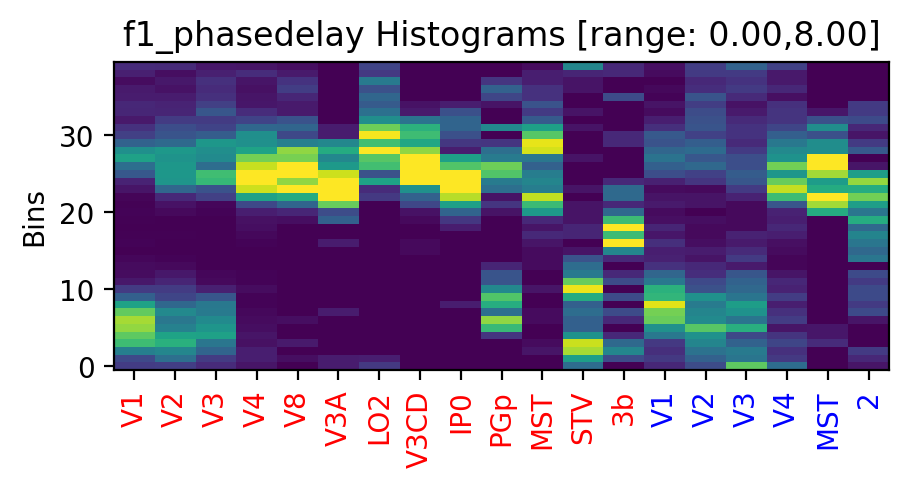

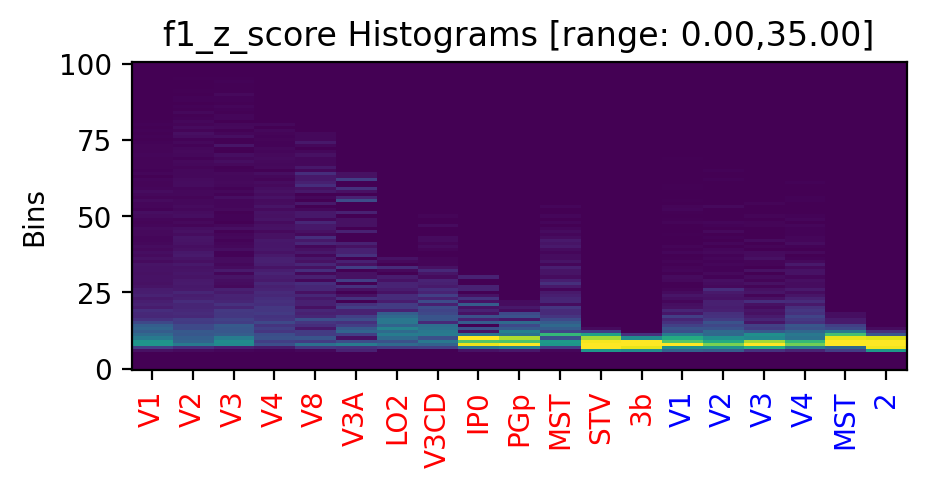

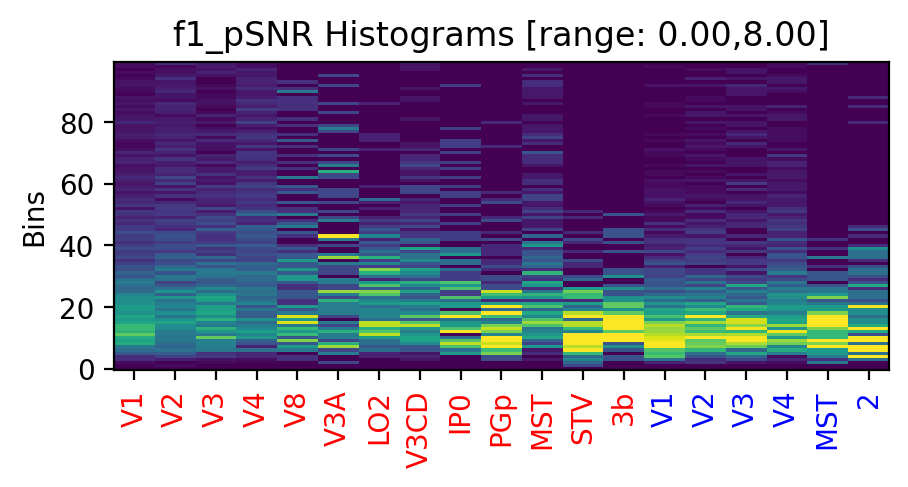

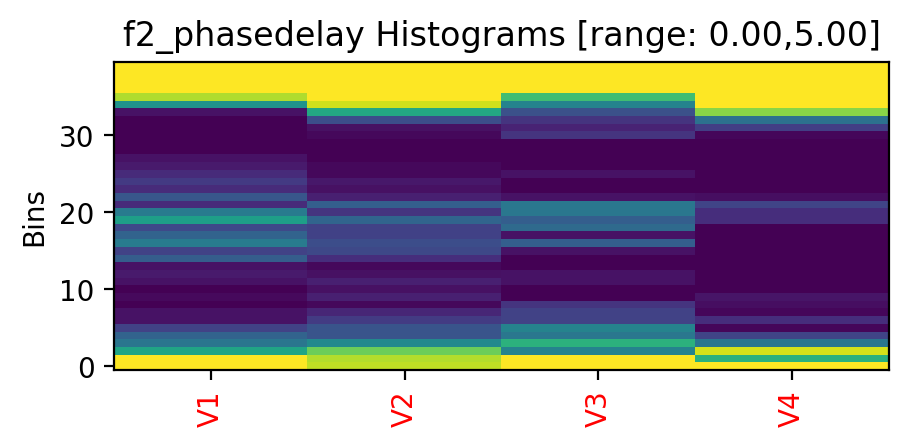

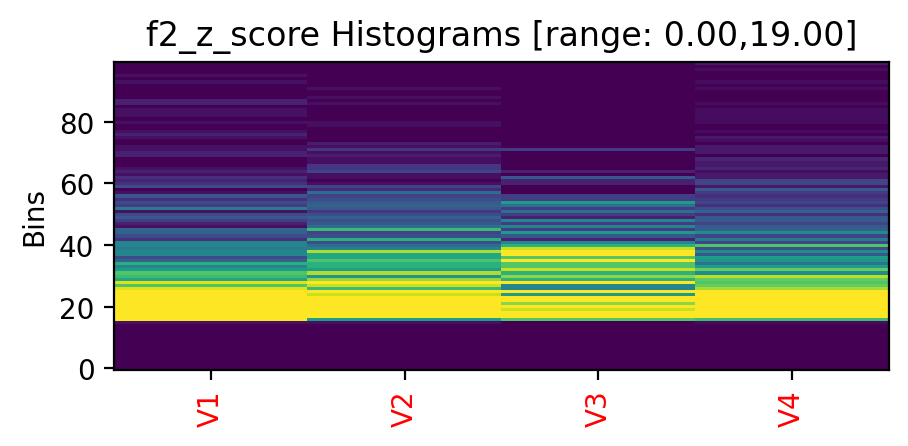

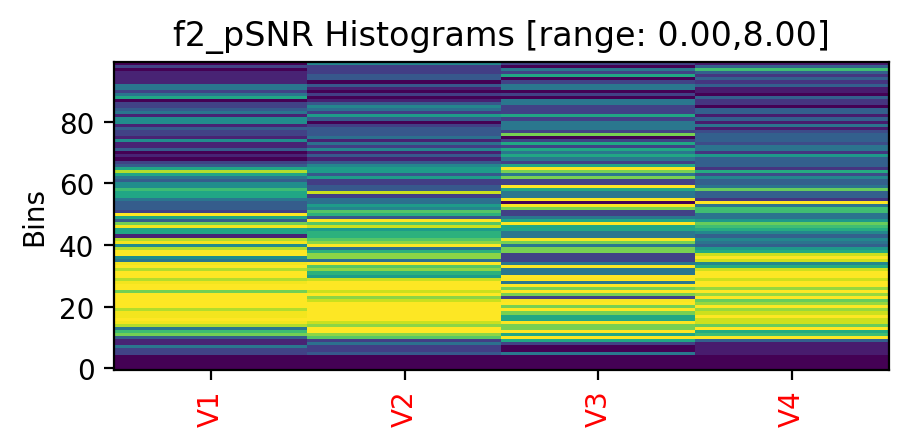

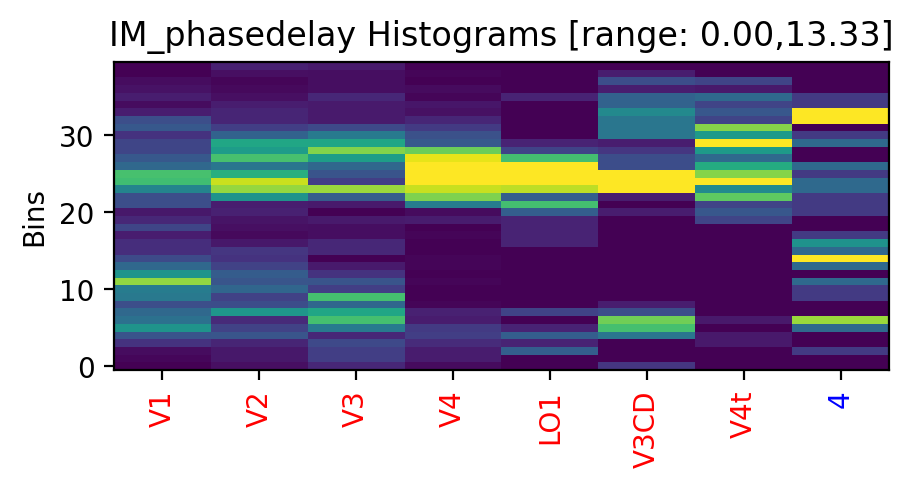

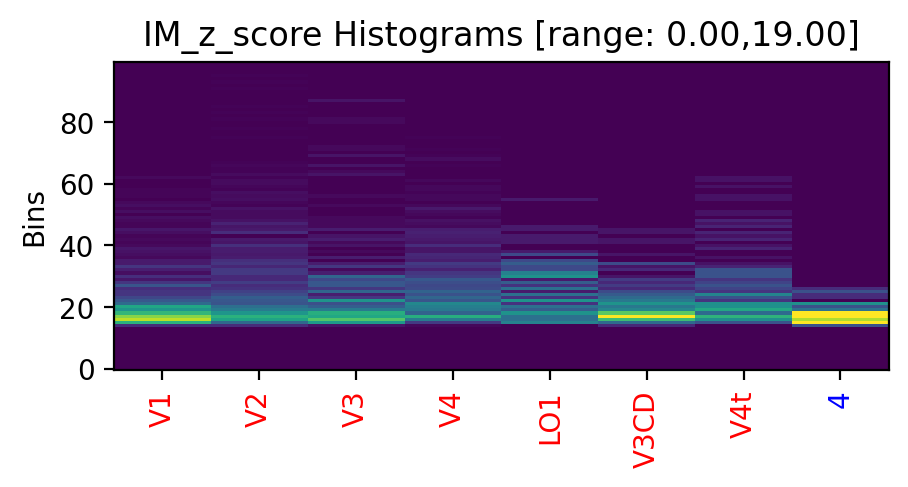

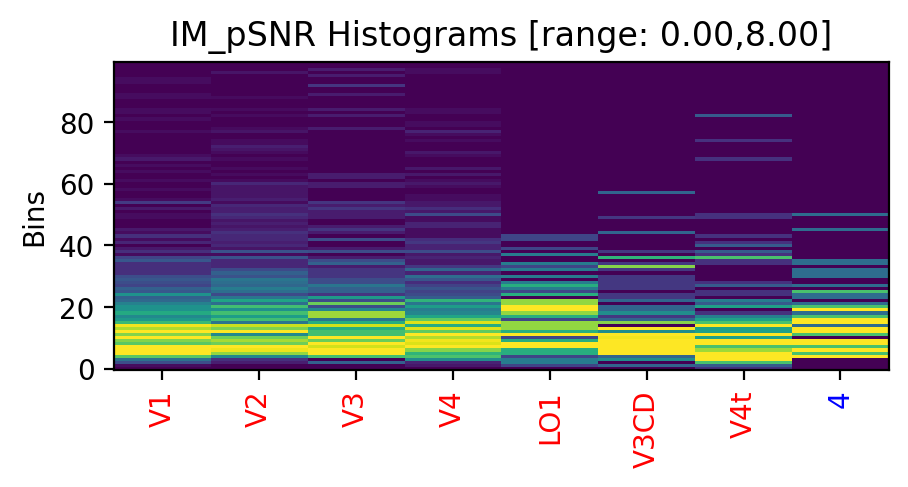

In [12]:
for k in contra_histograms.keys():
    plot_normalized_histograms(
        contra_histograms[k]+ipsi_histograms[k], 
        _contra_rois[k]+_ipsi_rois[k],
        k,
        [0, _contra_xmax[k][0]]
    )